Check markers on two additional mouse datasets not in atlas

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle as pkl

from sklearn.preprocessing import minmax_scale,maxabs_scale
from scipy.sparse import csr_matrix

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from importlib import reload  
import helper as h
reload(h)
import helper as h

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
path_rna='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_data=path_rna+'combined/'
path_clde=path_data+'beta_subtype_general/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [5]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [7]:
# Lad markers info
marker_info=pkl.load(open(path_clde+'markersCLparsed_leiden_r1.5_parsed_const_study_selected.pkl','rb'))

In [8]:
# Do not plot groups with less than this N cells
min_cells=5

In [9]:
# Known marekrs
markers={
    'beta':['Ins1','Ins2','Nkx6-1','Pdx1'],
    'imm.':['Rbp4','Cd81','Mafb'],
    'mature':['Mafa','Ucn3','Slc2a2'],
    'aged':['Cdkn2a','Trp53bp1'], 
    'T1D':['B2m'],
    'T2D':['Gast','Gc','Aldh1a3','Cck','Aldob','Chgb'],
    }

## GSE137909

### Prepare data

In [10]:
# Load data
ddir='GSE137909'+'/GEO/'
adata=sc.read(path_rna+ddir+'adata.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
adata.obs['age_months']=adata.obs.age.apply(lambda x: h.age_months(x)).astype(float)
summary=adata.obs.groupby(['donor','age','age_months','sex','STZ','insulin_implant']
                         ).size().reset_index().rename({0:'N'},axis=1).query('N>0')
summary['age_months']=summary['age_months'].astype(float)
display(summary.sort_values(['STZ','age_months','sex'],ascending=[False,True,True]))

Trying to set attribute `.obs` of view, copying.


,donor,age,age_months,sex,STZ,insulin_implant,N
4099,Ngn3Cre_STZ_D6_1,2.2 m,2.20,male,True,True,30
4727,Ngn3Cre_STZ_D12_1,2.4 m,2.40,male,True,True,16
5355,Ngn3Cre_STZ_D12_2,2.77 m,2.77,male,True,True,34
6031,Ngn3Cre_STZ_D30_1,3 m,3.00,male,True,True,28
6659,Ngn3Cre_STZ_D42_1,3.4 m,3.40,male,True,True,23
7287,Ngn3Cre_STZ_M2_1,4 m,4.00,male,True,True,8
7862,Ngn3Cre_STZ_M2_NoIns_1,4 m,4.00,male,True,False,5
8438,Ngn3Cre_STZ_M2_NoIns_2,4 m,4.00,male,True,False,11
9067,Ngn3Cre_STZ_M5_1,7 m,7.00,male,True,True,68
9695,Ngn3Cre_STZ_M9_1,11 m,11.00,male,True,True,57


C: Two mice have same metadata and are thus merged

In [11]:
# Keep donors with enough cells
donor_n=adata.obs.groupby('donor').size()
donor_keep=donor_n.index[donor_n>=min_cells].to_list()
print('Donors keep',donor_keep)
print('Donor drop',donor_n.index[donor_n<min_cells].to_list())
adata_sub=adata[adata.obs.donor.isin(donor_keep),:]

Donors keep ['Ngn3Cre_Control_1', 'Ngn3Cre_Control_2', 'Ngn3Cre_Control_3', 'Ngn3Cre_P3_1', 'Ngn3Cre_P12_1', 'Ngn3Cre_P12_2', 'Ngn3Cre_P21_1', 'Ngn3Cre_STZ_D6_1', 'Ngn3Cre_STZ_D12_1', 'Ngn3Cre_STZ_D12_2', 'Ngn3Cre_STZ_D30_1', 'Ngn3Cre_STZ_D42_1', 'Ngn3Cre_STZ_M2_1', 'Ngn3Cre_STZ_M2_NoIns_1', 'Ngn3Cre_STZ_M2_NoIns_2', 'Ngn3Cre_STZ_M5_1', 'Ngn3Cre_STZ_M9_1']
Donor drop []


Dotplot categories

In [ ]:
# Make dotplot categories
# Combine disease, age in years, and sex
adata_sub.obs['category']=[' '.join(
    ['STZ',str(d),'ins',str(i),str(round(a,1)).rstrip('.0')+'m',s]) 
                           for d,i,a,s in zip(
    adata_sub.obs['STZ'],adata_sub.obs['insulin_implant'],
    adata_sub.obs['age_months'],adata_sub.obs['sex'])]
adata_sub.obs['category']=pd.Categorical(
    values=adata_sub.obs['category'],ordered=True,
    # Make categories ordered by disease, ins, age, and sex
    categories=adata_sub.obs.drop_duplicates('category').sort_values(
        ['STZ','insulin_implant','age_months','sex'],
        ascending=[False,True,True,True]).category.to_list())

In [13]:
# List categories
adata_sub.obs.drop_duplicates('category').sort_values(
        ['STZ','insulin_implant','age_months','sex'],
        ascending=[False,True,True,True]).category.to_list()

['STZ True ins False 4m male',
 'STZ True ins True 2.2m male',
 'STZ True ins True 2.4m male',
 'STZ True ins True 2.8m male',
 'STZ True ins True 3m male',
 'STZ True ins True 3.4m male',
 'STZ True ins True 4m male',
 'STZ True ins True 7m male',
 'STZ True ins True 11m male',
 'STZ False ins False 0.1m male',
 'STZ False ins False 0.4m male',
 'STZ False ins False 0.7m male',
 'STZ False ins False 2m male',
 'STZ False ins False 4m male']

Plot marker expression across all metadata groups

In [14]:
# Select markers present in data
plot_markers=defaultdict(list)
for group,eids_mm in marker_info.items():
    # Match group to parsed cluster names
    #group=cl_map[group]
    for eid_mm in eids_mm:
        if eid_mm in adata.var_names and isinstance(adata.var.loc[eid_mm,'gene_symbol'],str):
            plot_markers[group].append(adata.var.loc[eid_mm,'gene_symbol'])
        else:
            raise ValueError('Missing',eid_mm)

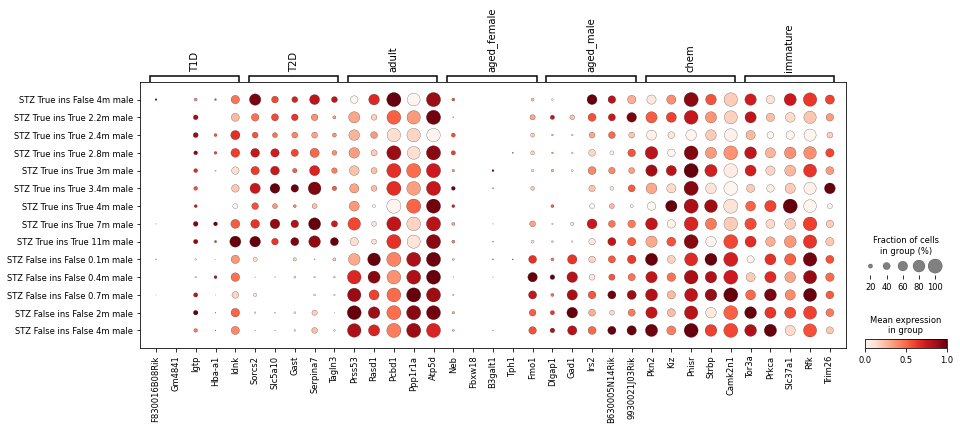

In [59]:
sc.pl.dotplot(adata_sub,var_names=plot_markers,gene_symbols='gene_symbol',
              groupby='category',standard_scale='var',)

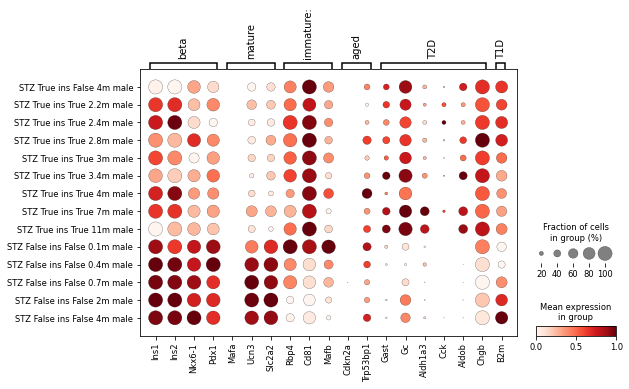

In [133]:
# Known markers
markers_sub={}
# Want to plot all markers so need to adapt otherwise
#for group,gss in markers.items():
#    markers_sub[group]=[gs for gs in gss if gs in adata.var.gene_symbol.values]
sc.pl.dotplot(adata_sub,var_names= markers, groupby='category', 
              gene_symbols='gene_symbol',standard_scale='var')

### Summarise metadata groups
Group further categories for concise plot

In [15]:
# Make dotplot categories
# Separate into age (only healthy), diabetes, diabetes ins treated
adata.obs['category']=[' '.join(
    ['STZ'+('+ins' if i else '') if d else 'healthy',
     str(round(a,1)).rstrip('.0')+'m' if not d else 'adult'])
                           for d,i,a in zip(
    adata.obs['STZ'],adata.obs['insulin_implant'],
    adata.obs['age_months'])]

In [16]:
adata.obs['category'].unique()

array(['healthy 2m', 'healthy 4m', 'STZ+ins adult', 'STZ adult',
       'healthy 0.4m', 'healthy 0.7m', 'healthy 0.1m'], dtype=object)

In [17]:
# Make categories ordered by disease, ins, age, and sex
adata.obs['category']=pd.Categorical(
    values=adata.obs['category'],ordered=True,
    categories=adata.obs.drop_duplicates('category').sort_values(
        ['STZ','insulin_implant','age_months'],
        ascending=[False,True,True]).category.to_list())

In [18]:
# categories and N cells
adata.obs['category'].value_counts(sort=False)

STZ adult         16
STZ+ins adult    264
healthy 0.1m     123
healthy 0.4m     128
healthy 0.7m     105
healthy 2m       210
healthy 4m       159
Name: category, dtype: int64

Plot new and known markers

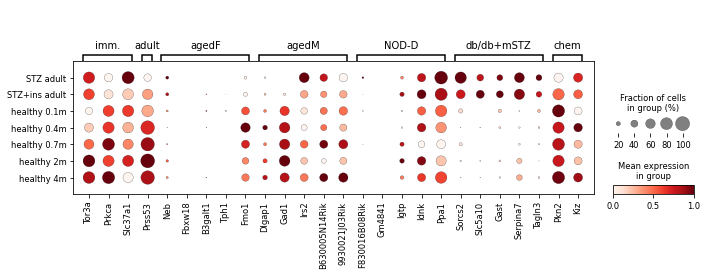

In [20]:
sc.pl.dotplot(adata,var_names=plot_markers,gene_symbols='gene_symbol',
              groupby='category',standard_scale='var',show=False,var_group_rotation=0,)
plt.savefig(path_fig+'dotplot_beta_CLcoarse_newmarkers_otherMouse.png',
            dpi=300,bbox_inches='tight')

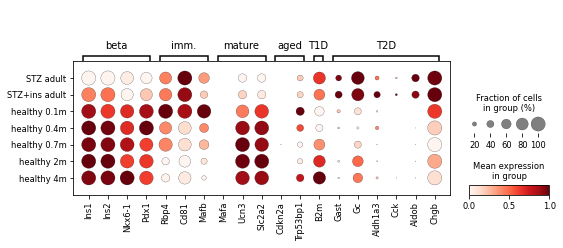

In [21]:
# Known markers
sc.pl.dotplot(adata,var_names= markers, groupby='category', var_group_rotation=0,
              gene_symbols='gene_symbol',standard_scale='var',show=False)

plt.savefig(path_fig+'dotplot_beta_CLcoarse_knownmarkers_otherMouse.png',
            dpi=300,bbox_inches='tight')

#### Expected marker populations
Plot only marker populations expected to be present in the data

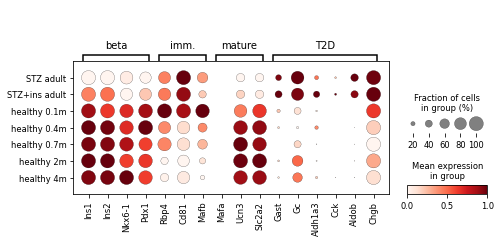

In [22]:
markers_sub={k:v.copy() for k,v in markers.items()}
for k in ['aged','T1D']:
    del markers_sub[k]
sc.pl.dotplot(adata,var_names= markers_sub, groupby='category', var_group_rotation=0,
              gene_symbols='gene_symbol',standard_scale='var',show=False)

plt.savefig(path_fig+'dotplot_beta_CLcoarse_knownmarkersSub_otherMouse.png',
            dpi=300,bbox_inches='tight')

Plot of new markers. Add space in the plot to show how an ideal marker would loook like on this dataset (colorbar then added manually in keynote).

In [23]:
# Subset to markers expected to be variable in data
plot_markers_sub={}
for k,v in plot_markers.items():
    # Just copy not ok as lists (values) of dict are not copied
    if k  in ['imm.','adult','db/db+mSTZ']:
        plot_markers_sub[k]=v.copy()
display(plot_markers_sub)    

{'imm.': ['Tor3a', 'Prkca', 'Slc37a1'],
 'adult': ['Prss53'],
 'db/db+mSTZ': ['Sorcs2', 'Slc5a10', 'Gast', 'Serpina7', 'Tagln3']}

In [24]:
# Add ideal markers to plot markers
plot_markers_sub_ideal={k:v.copy() for k,v in plot_markers_sub.items()}
for k in plot_markers_sub_ideal:
    plot_markers_sub_ideal[k].insert(0,'ideal '+k)

In [25]:
# New adata temp for plotting with "ideal" genes
# Already map to gene symbols
eids_use=[e for gs in plot_markers_sub.values() for g in gs 
          for e in adata.var.query('gene_symbol==@g').index]
adata_temp=adata[:,eids_use].copy()
adata_temp.var_names=adata_temp.var['gene_symbol'].values
adata_temp=sc.concat([adata_temp, 
                     sc.AnnData(
                         pd.DataFrame(np.zeros((adata_temp.shape[0],len(plot_markers_sub))),
                         index=adata_temp.obs_names,
                         columns=['ideal '+g for g in plot_markers_sub]))],
                     axis=1)
adata_temp.obs=adata.obs.copy()

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Tor3a', 'Prkca', 'Slc37a1', 'Prss53', 'Sorcs2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


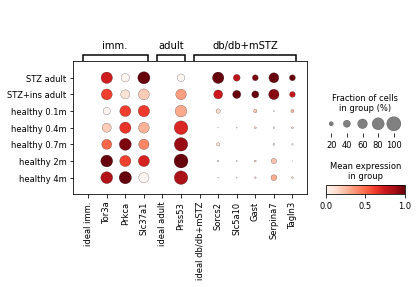

In [27]:
sc.pl.dotplot(adata_temp,var_names=  plot_markers_sub_ideal, groupby='category', 
              standard_scale='var',show=False, var_group_rotation=0,)
plt.savefig(path_fig+'dotplot_beta_CLcoarse_newmarkers_otherMouse_idealSpace.png',
            dpi=300,bbox_inches='tight')

### GSE83146

Prepare data

In [70]:
ddir='GSE83146'+'/GEO/'
adata=sc.read(path_rna+ddir+'adata.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
adata.obs['age_months']=adata.obs.age.apply(lambda x: h.age_months(x)).astype(float)
summary=adata.obs.groupby(['age','age_months','sex']
                         ).size().reset_index().rename({0:'N'},axis=1).query('N>0')
summary['age_months']=summary['age_months'].astype(float)
display(summary.sort_values(['age','age_months','sex'],ascending=[True,True,True]))

Trying to set attribute `.obs` of view, copying.


,age,age_months,sex,N
0,3 m,3.0,male,138
3,26 m,26.0,male,69


C: The dataset is quite small.

Dotplots - due to only 2 cell groups also do plots without gene-wise scaling.

In [71]:
adata_sub=adata.copy()

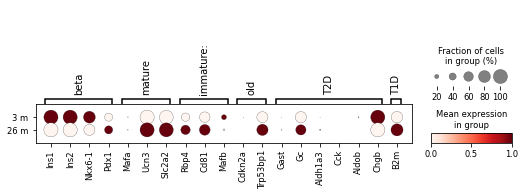

In [61]:
# Known markers
markers_sub={}
for group,gss in markers.items():
    markers_sub[group]=[gs for gs in gss if gs in adata.var.gene_symbol.values]
sc.pl.dotplot(adata_sub,var_names= markers_sub, groupby='age', 
              gene_symbols='gene_symbol',standard_scale='var')

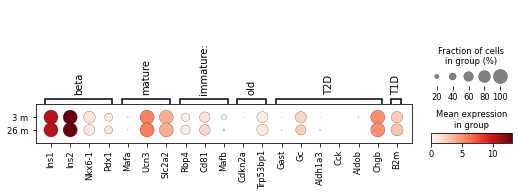

In [62]:
# Known markers
markers_sub={}
for group,gss in markers.items():
    markers_sub[group]=[gs for gs in gss if gs in adata.var.gene_symbol.values]
sc.pl.dotplot(adata_sub,var_names= markers_sub, groupby='age', 
              gene_symbols='gene_symbol')

C: Expression of known markers does not make sense (absence of expected differences). Thus this dataset can not be used. Not sure why the known markers do not work.

Just for comparison also plot the new markers, although based on the above known markers it is not to be expected that they will work.

In [80]:
# Select markers present in data
plot_markers=defaultdict(list)
for group,data in ups.groupby('cluster'):
    eids_mm=data.query('beta_rel_expr>0.7'
                        ).sort_values('logFC',ascending=False).head(5).index.to_list()
    for eid_mm in eids_mm:
        symbols=adata.var.query('EID==@eid_mm')['gene_symbol']
        plot_markers[group].extend(symbols)

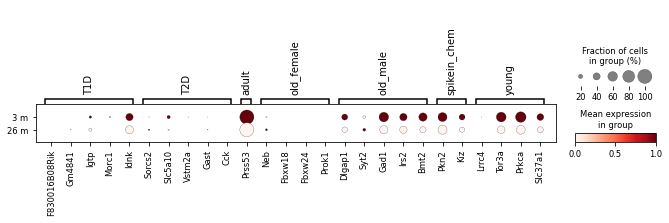

In [81]:
sc.pl.dotplot(adata_sub,var_names=plot_markers,gene_symbols='gene_symbol',
              groupby='age',standard_scale='var',)

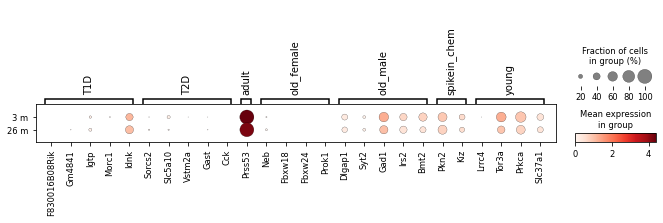

In [82]:
sc.pl.dotplot(adata_sub,var_names=plot_markers,gene_symbols='gene_symbol',
              groupby='age',)

C: Many new markers are extremely lowly expressed.